**If you like my notebook, please upvote my work!**

**If you use parts of this notebook in your scripts/notebooks, giving some kind of credit for instance link back to this notebook would be very much appreciated. Thanks in advance! :)**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bike-sharing-demand/test.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv


# Importing important libraries

In [2]:
import calendar
import seaborn as sb
import xgboost as xgb
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error,make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV

# Loading the training dataset

In [3]:
#Reading the file
file = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")

In [4]:
file.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# Checking for null values

In [5]:
file.isnull().sum(axis=0)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

No data cleaning is required since no Null values are found!

In [6]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

# Data visualization:

## Heatmap of all the continuous values in the file.

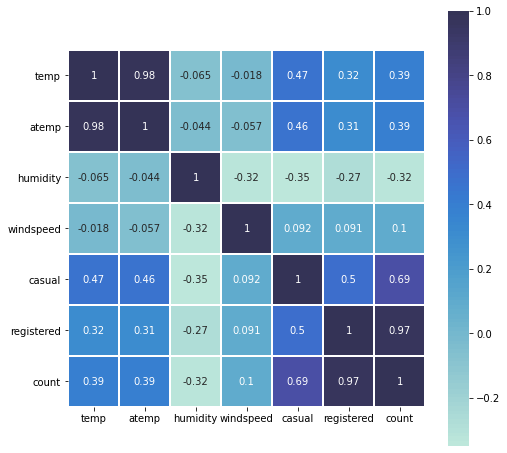

In [7]:
corr = file[['temp','atemp','humidity', 'windspeed','casual', 'registered','count']].corr()
f,axes = plt.subplots(1,1,figsize = (8,8))
sb.heatmap(corr,square=True,annot = True,linewidth = .5,center = 1.4,ax = axes)

### The conclusions drawn are:
1. We can see that temp and atemp have a very strong positive correlation therefore we can use only temp as a variable without any loss of information. 

2. We can infer from the correlaton matrix that windspeed has almost no correlation with the casual,registered or count which we wish to predict so we can remove that

## Data visualizaton for non continuous variables in data

First we have to separate the individual date and time for each data point into hour,day,month and year.

In [8]:
file = file
file['Date'] = pd.DatetimeIndex(file['datetime']).date
file['Hour'] = pd.DatetimeIndex(file['datetime']).hour
file['Day'] = pd.DatetimeIndex(file['datetime']).day
file['Month'] = pd.DatetimeIndex(file['datetime']).month
file['Year'] = pd.DatetimeIndex(file['datetime']).year
file['Weekday'] = pd.DatetimeIndex(file['datetime']).weekday_name

In [9]:
a = []
for i in file.index:
    a.append('Total Count : '+str(file['count'][i]))
file['count_vis'] = a

In [10]:
fig = px.line(x = 'Date', y = "count", data_frame = file,color = 'Hour',range_y = (0,1150),
              title = 'Interactive LinePlot of the whole dataset(Hover for more details)',
              hover_data = ['Hour','Date','casual','registered'],
              hover_name = 'count_vis', text = None,
              height = 670,width = 980)
fig.show()

**The sudden periodic changes between the differrent regions is due to the missing data.These are the regions in which the regions we have to predict the result.**

## 1. Season

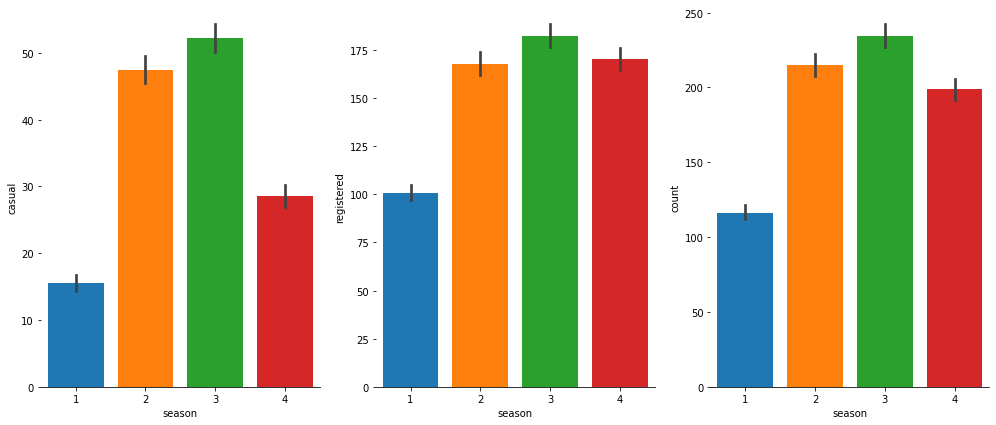

In [11]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'season'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

## 2. Holiday

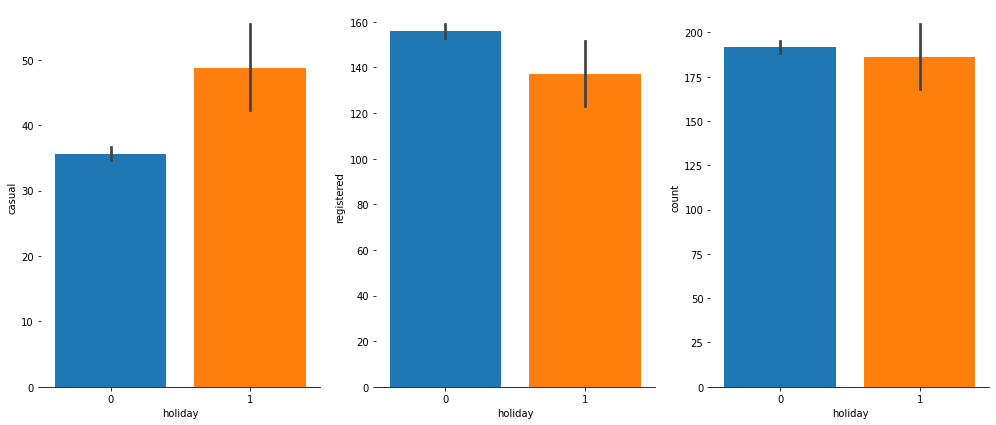

In [12]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'holiday'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

## 3. Working day

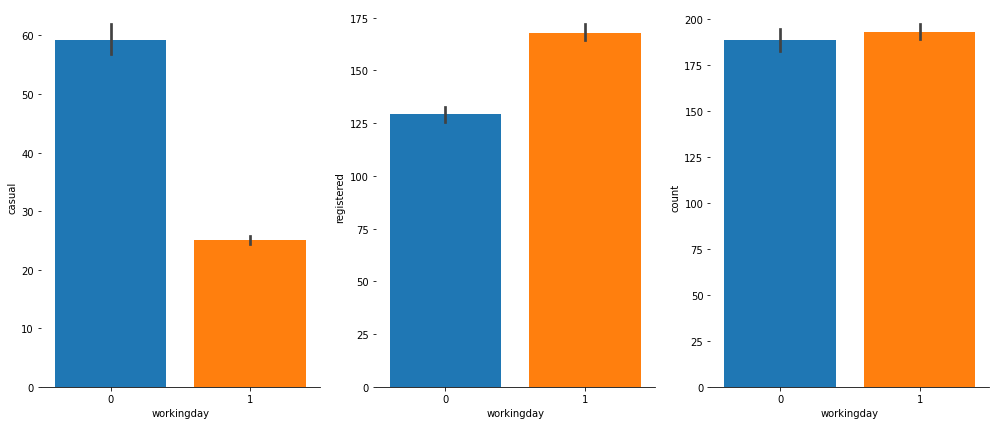

In [13]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'workingday'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

Combining the graphs of casual and registered into one of may make it seem like that holiday and workingday have no dependence on count but we can clearly see that holiday increases the casual amount by upto 40% and a reverse kind of trend is observed in working day so it is reasonable to take two different models one for casual and another for registered.

Therefore what I will attempt to do is make two separate models for the casual and the registerd training them separately and then adding the result to get the count.

## 4. Weather

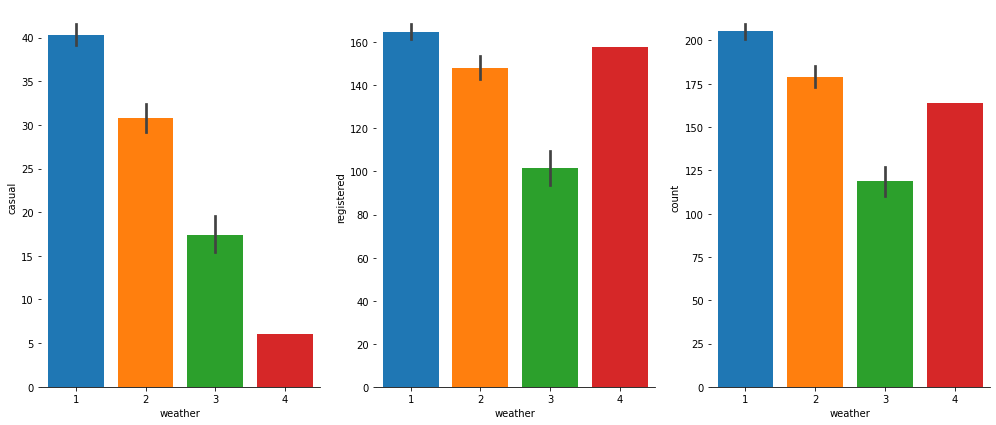

In [14]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'weather'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

## 5. Date and Time

### 5.a. Hour

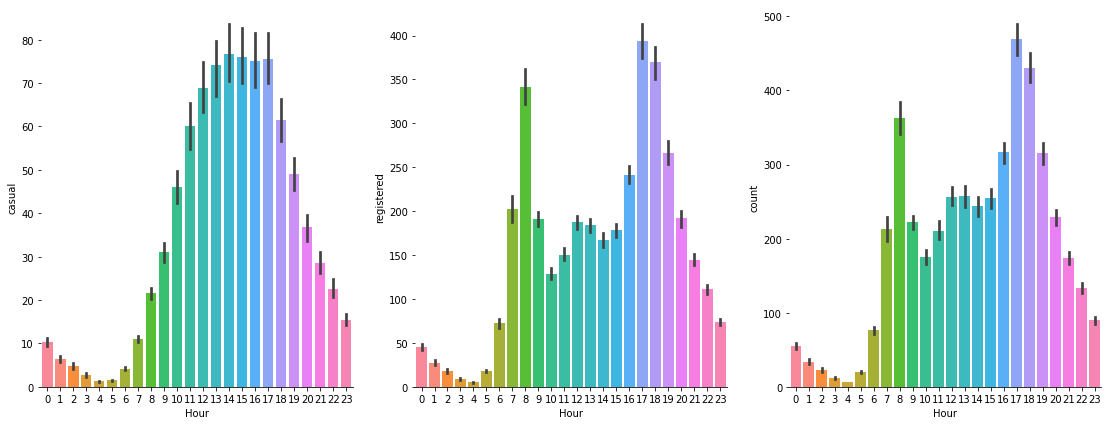

In [15]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Hour'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

We can see that in the final graph there are two prominent peaks.
1. At 8 a.m
2. At 5 p.m
Where as the trend of casual is mostly the same throughout the day. 

From this we can conclude that the registered are mostly people going on their jobs which explains the peaks at the start and end of office hours. Clearly these people would have a more definite and predictible schedule and are therefore more likely to be registered.In order to test this we plot somw more graphs.

In [16]:
file.groupby('Weekday').count().index

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object', name='Weekday')

In [17]:
file1 = file.groupby(['Hour','Weekday']).mean().reset_index()
dic = {'Weekday':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']}
dic1 = {'registered':'Average count of registered poeple commuting.','count': 'Average people commuting','Hour':'Hour of the day',
        'Weekday':'Day of the week'}
fig = px.line(x = 'Hour', y = "registered", data_frame = file1.reset_index(),color = 'Weekday',
              title = 'Interactive LinePlot of the registered separated by weekday(Hover for more details)',labels = dic1,
              hover_data = ['count'],category_orders = dic,range_y = [0,550],height = 670,width = 980)
fig.show()

Clearly We can see that on the days of saturday and sunday,the general trend more or less follows the trend of casual where as on weekdays there is a completely different trend of two peaks at 8 am and 5 pm which confirms that those peaks are due to the workpeople commuting.

### 5.b. Day

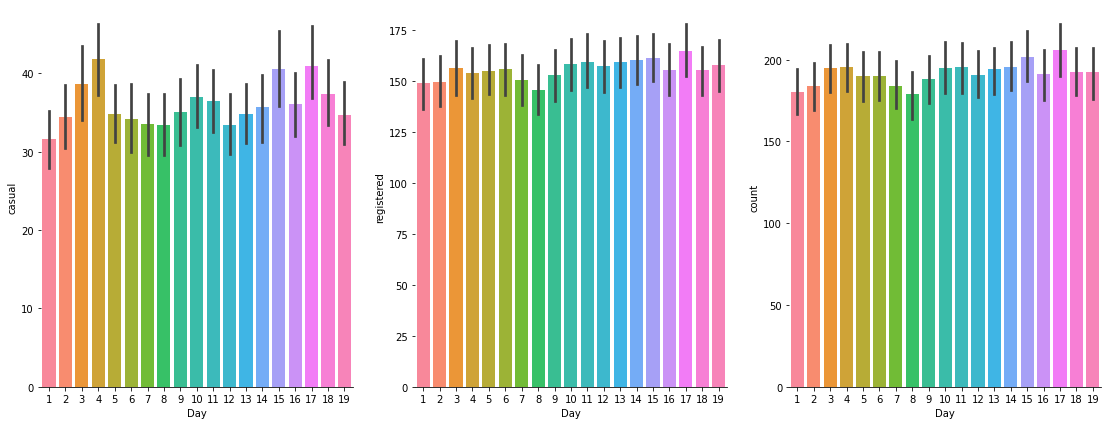

In [18]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Day'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

**From the above graphs we can conclude that the feature day has hardly any influence over the features registered and count.**

### 5.c. Month

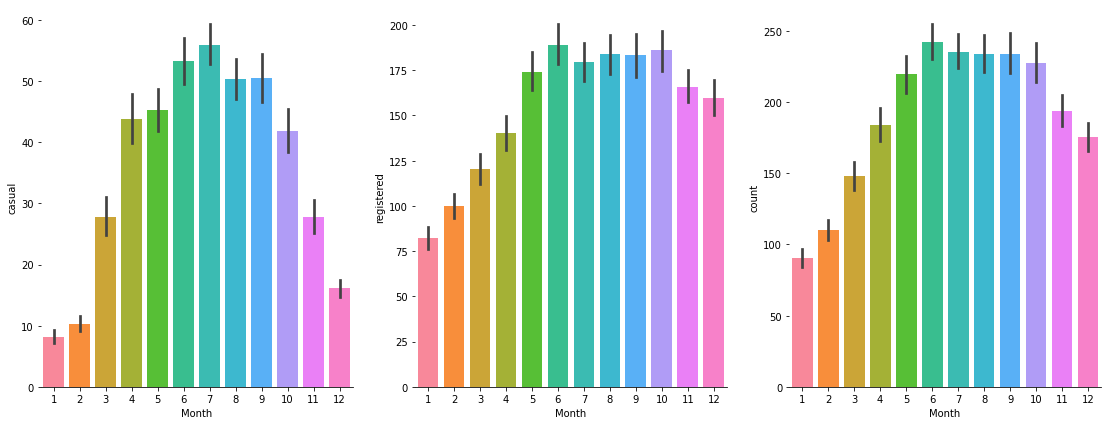

In [19]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Month'
#order = ['January','February','March','April','May','June','July','August','September','October','November','December']
plot = sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

### 5.d. Year 

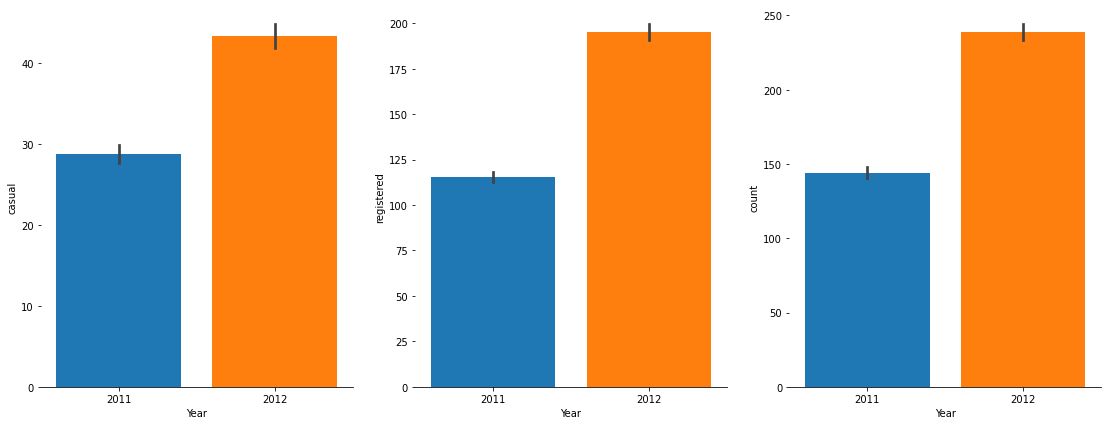

In [20]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Year'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

In [21]:
file.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Hour,Day,Month,Year
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,9.992559,6.521495,2011.501929
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,5.476608,3.444373,0.500019
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2011.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,5.000000,4.000000,2011.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,10.000000,7.000000,2012.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,15.000000,10.000000,2012.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,19.000000,12.000000,2012.000000


In [22]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Date', 'Hour', 'Day', 'Month', 'Year', 'Weekday', 'count_vis'],
      dtype='object')

# Adding relevant columns for each of the categorical data columns and removing unnecesary ones

## 1. Season

In [23]:
for i in file.groupby('season').count().index:
    s = 's'+str(i)
    a=[]
    for j in file.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s]=a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Hour,Day,Month,Year,Weekday,count_vis,s1,s2,s3,s4
6238,2012-02-16 04:00:00,1,0,1,3,12.30,15.910,70,6.0032,0,...,4,16,2,2012,Thursday,Total Count : 3,1,0,0,0
5306,2011-12-15 04:00:00,4,0,1,2,13.12,15.150,70,15.0013,0,...,4,15,12,2011,Thursday,Total Count : 6,0,0,0,1
9394,2012-09-14 19:00:00,3,0,1,1,27.88,31.820,57,11.0014,83,...,19,14,9,2012,Friday,Total Count : 579,0,0,1,0
4990,2011-12-02 00:00:00,4,0,1,1,10.66,14.395,70,6.0032,6,...,0,2,12,2011,Friday,Total Count : 38,0,0,0,1
7628,2012-05-17 05:00:00,2,0,1,1,22.96,26.515,68,22.0028,1,...,5,17,5,2012,Thursday,Total Count : 35,0,1,0,0


## 2. Weather 

In [24]:
for i in file.groupby('weather').count().index:
    s = 'w'+str(i)
    a=[]
    for j in file.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s]=a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Weekday,count_vis,s1,s2,s3,s4,w1,w2,w3,w4
2944,2011-07-11 14:00:00,3,0,1,1,35.26,41.665,53,19.0012,40,...,Monday,Total Count : 134,0,0,1,0,1,0,0,0
7367,2012-05-06 08:00:00,2,0,0,2,20.50,24.240,88,8.9981,23,...,Sunday,Total Count : 114,0,1,0,0,0,1,0,0
95,2011-01-05 04:00:00,1,0,1,1,9.84,11.365,48,15.0013,0,...,Wednesday,Total Count : 2,1,0,0,0,1,0,0,0
6947,2012-04-07 19:00:00,2,0,0,1,22.14,25.760,16,22.0028,170,...,Saturday,Total Count : 413,0,1,0,0,1,0,0,0
7066,2012-04-12 19:00:00,2,0,1,1,18.86,22.725,31,19.9995,50,...,Thursday,Total Count : 433,0,1,0,0,1,0,0,0


## 3. Hour

In [25]:
for i in file.groupby('Hour').count().index:
    s = 'Hour'+str(i)
    a=[]
    for j in file.Hour:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s]=a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23
2452,2011-06-10 02:00:00,2,0,1,1,27.88,31.820,69,11.0014,6,...,0,0,0,0,0,0,0,0,0,0
7003,2012-04-10 03:00:00,2,0,1,1,14.76,17.425,71,8.9981,0,...,0,0,0,0,0,0,0,0,0,0
7123,2012-04-15 04:00:00,2,0,0,2,22.14,25.760,52,0.0000,2,...,0,0,0,0,0,0,0,0,0,0
3076,2011-07-17 02:00:00,3,0,0,1,26.24,30.305,69,15.0013,28,...,0,0,0,0,0,0,0,0,0,0
7383,2012-05-07 00:00:00,2,0,1,2,21.32,25.000,77,8.9981,13,...,0,0,0,0,0,0,0,0,0,0


## 4.Month

In [26]:
for i in file.groupby("Month").count().index:
    s = 'Month' + str(i)
    a = []
    for j in file.Month:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s] = a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12
6138,2012-02-12 00:00:00,1,0,0,3,4.10,3.790,68,26.0027,0,...,0,0,0,0,0,0,0,0,0,0
4381,2011-10-14 14:00:00,4,0,1,1,25.42,31.060,43,23.9994,37,...,0,0,0,0,0,0,0,1,0,0
6626,2012-03-13 09:00:00,1,0,1,1,19.68,23.485,82,19.0012,18,...,1,0,0,0,0,0,0,0,0,0
5130,2011-12-07 20:00:00,4,0,1,3,13.94,14.395,87,43.0006,1,...,0,0,0,0,0,0,0,0,0,1
4053,2011-09-19 22:00:00,3,0,1,2,22.96,26.515,68,11.0014,25,...,0,0,0,0,0,0,1,0,0,0


In [27]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Date', 'Hour', 'Day', 'Month', 'Year', 'Weekday', 'count_vis', 's1',
       's2', 's3', 's4', 'w1', 'w2', 'w3', 'w4', 'Hour0', 'Hour1', 'Hour2',
       'Hour3', 'Hour4', 'Hour5', 'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10',
       'Hour11', 'Hour12', 'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17',
       'Hour18', 'Hour19', 'Hour20', 'Hour21', 'Hour22', 'Hour23', 'Month1',
       'Month2', 'Month3', 'Month4', 'Month5', 'Month6', 'Month7', 'Month8',
       'Month9', 'Month10', 'Month11', 'Month12'],
      dtype='object')

## Removing unnecessary columns

In [28]:
feed = file[['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5',
       'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12',
       'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19',
       'Hour20', 'Hour21', 'Hour22', 'Hour23','Month1', 'Month2', 'Month3',
       'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10',
       'Month11', 'Month12','Year','s1','s2','s3','s4','holiday','workingday',
        'w1','w2','w3','w4','temp','humidity','casual','registered']]

In [29]:
feed.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,holiday,workingday,w1,w2,w3,w4,temp,humidity,casual,registered
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460,36.021955,155.552177
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033,49.960477,151.039033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000,4.000000,36.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000,17.000000,118.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000,49.000000,222.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000,367.000000,886.000000


In [30]:
feed.columns

Index(['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5', 'Hour6', 'Hour7',
       'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12', 'Hour13', 'Hour14',
       'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19', 'Hour20', 'Hour21',
       'Hour22', 'Hour23', 'Month1', 'Month2', 'Month3', 'Month4', 'Month5',
       'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12',
       'Year', 's1', 's2', 's3', 's4', 'holiday', 'workingday', 'w1', 'w2',
       'w3', 'w4', 'temp', 'humidity', 'casual', 'registered'],
      dtype='object')

# Preparing training and testing sets

### 1. Training set

In [31]:
df_train_x = feed.drop('casual',axis = 1).drop('registered',axis=1)
df_train_x.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,s3,s4,holiday,workingday,w1,w2,w3,w4,temp,humidity
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.251056,0.251148,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.433641,0.433694,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000


### 2. Training set

In [32]:
df_reg_train_y = feed['registered']
df_reg_train_y.describe

<bound method NDFrame.describe of 0         13
1         32
2         27
3         10
4          1
        ... 
10881    329
10882    231
10883    164
10884    117
10885     84
Name: registered, Length: 10886, dtype: int64>

In [33]:
df_cas_train_y = feed['casual']
df_cas_train_y.describe

<bound method NDFrame.describe of 0         3
1         8
2         5
3         3
4         0
         ..
10881     7
10882    10
10883     4
10884    12
10885     4
Name: casual, Length: 10886, dtype: int64>

# Machine learning model

### Splitting data into train and test sets

In [34]:
x1_train, x1_test, y1_train, y1_test = train_test_split(df_train_x, df_cas_train_y, test_size=0.15, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(df_train_x, df_reg_train_y, test_size=0.15, random_state=42)

### Using polynomial on the dataset

In [35]:
poly = PolynomialFeatures(degree=2)
poly_x1_train = poly.fit_transform(x1_train)
poly_x1_test = poly.fit_transform(x1_test)
poly_x2_train = poly.fit_transform(x2_train)
poly_x2_test = poly.fit_transform(x2_test)

### Trying different models to see which one works best for the given data.

In [36]:
rf = RandomForestRegressor()

parameters = {'n_estimators':[50,100,150,200,250],
              'min_impurity_decrease':[0.0,0.001,0.01],
              'max_depth':[20,40,60,80,100]}

models = ['Normal Linear Regression: ','Linear Regression over polynomial: ',
          'Decision Tree Regressor: ','XG Boosting: ']

### Defining a custom scorer function for the models

In [37]:
def custom_scorer(y_true,y_pred):
    for i in range(len(y_pred)):
        if y_pred[i]<0:
            y_pred[i] = 1
    return np.sqrt(mean_squared_log_error(y_true, y_pred ))
scorer = make_scorer(custom_scorer,greater_is_better = False)

Here I have defined a scorer function as we are using mean squared log loss which does not work on negative values and the models were sometimes predicting negative values which messes with the scores and since we know that these values will always be positive we just replace them with the minimum value in the train set which is 1.

In [38]:
predict = []
reg = LinearRegression().fit(x1_train, y1_train)
pre_reg = reg.predict(x1_test)

reg_poly = LinearRegression().fit(poly_x1_train, y1_train)
pre_reg_poly = reg_poly.predict(poly_x1_test)

rf_reg = GridSearchCV(rf, parameters, cv=5, verbose=2,scoring = scorer,n_jobs = -1)
rf_reg.fit(x1_train, y1_train)
pre_rf_reg = rf_reg.predict(x1_test)

predict.append(pre_reg)
predict.append(pre_reg_poly)
predict.append(pre_rf_reg)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.7s
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 12.9min finished


In [39]:
for prediction in range(len(predict)):
    pre = []
    for p in predict[prediction]:
        if p < 1:
            pre.append(1)
        else:
            pre.append(p)
    print(models[prediction]+str(np.sqrt(mean_squared_log_error(y1_test, pre ))))

Normal Linear Regression: 1.021087822864223
Linear Regression over polynomial: 0.8901384204865517
Decision Tree Regressor: 0.6544061850000844


In [40]:
predict = []
cas = LinearRegression().fit(x2_train, y2_train)
pre_cas = cas.predict(x2_test)

cas_poly = LinearRegression().fit(poly_x2_train, y2_train)
pre_cas_poly = cas_poly.predict(poly_x2_test)

rf_cas = GridSearchCV(rf, parameters, cv=5, verbose=2,scoring = scorer,n_jobs = -1)
rf_cas.fit(x2_train, y2_train)
pre_rf_cas = rf_cas.predict(x2_test)

predict.append(pre_cas)
predict.append(pre_cas_poly)
predict.append(pre_rf_cas)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.3min
/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 14.0min finished


In [41]:
for prediction in range(len(predict)):
    pre = []
    for p in predict[prediction]:
        if p < 1:
            pre.append(1)
        else:
            pre.append(p)
    print(models[prediction]+str(np.sqrt(mean_squared_log_error(y2_test, pre ))))

Normal Linear Regression: 1.004323087654508
Linear Regression over polynomial: 0.6565935912143859
Decision Tree Regressor: 0.4159014227926196


In [42]:
print("For Random Forest Model: ")
print("\t Best Parametres for registered are: ",end='')
print(rf_reg.best_params_)
print("\t Best Parametres for casual are: ",end = '')
print(rf_cas.best_params_)

For Random Forest Model: 
	 Best Parametres for registered are: {'max_depth': 80, 'min_impurity_decrease': 0.001, 'n_estimators': 150}
	 Best Parametres for casual are: {'max_depth': 60, 'min_impurity_decrease': 0.01, 'n_estimators': 150}


In [43]:
predict1 = []

reg1 = LinearRegression().fit(x1_train, y1_train)
pre_reg1 = reg1.predict(x1_test)

reg1_poly = LinearRegression().fit(poly_x1_train, y1_train)
pre_reg1_poly = reg1_poly.predict(poly_x1_test)

rf1 = RandomForestRegressor(n_estimators = 200,max_depth=80,min_impurity_decrease = 0.001).fit(x1_train, y1_train)
pre_rf1 = rf1.predict(x1_test)

for i in range(pre_reg1.size):
    if pre_reg1[i]<1:
        pre_reg1[i] = 1 
    if pre_reg1_poly[i]<1:
        pre_reg1_poly[i] = 1
    if pre_rf1[i]<1:
        pre_rf1[i] = 1

predict1.append(pre_reg1)
predict1.append(pre_reg1_poly)
predict1.append(pre_rf1)

x1_final = x1_test.copy()
x1_final['Output'] = y1_test
x1_final['Lin_reg'] = pre_reg1
x1_final['Lin_reg_poly'] = pre_reg1_poly
x1_final['RF_reg'] = pre_rf1
x1_final['Resid'] = y1_test-pre_reg1
x1_final['Resid_poly'] = y1_test-pre_reg1_poly

for prediction in predict1:
    print(np.sqrt(mean_squared_log_error( y1_test, prediction )))

1.021087822864223
0.8901384204865517
0.6523596760729161


Since we know that the output is never less than 1 we replace all negative values with 1 before appending in pre to calculate error.

In [44]:
predict2 = []

reg2 = LinearRegression().fit(x2_train, y2_train)
pre_reg2 = reg2.predict(x2_test)

reg2_poly = LinearRegression().fit(poly_x2_train, y2_train)
pre_reg2_poly = reg2_poly.predict(poly_x2_test)

rf2 = RandomForestRegressor(n_estimators = 150,max_depth=60,min_impurity_decrease = 0.0).fit(x2_train, y2_train)
pre_rf2 = rf2.predict(x2_test)

for i in range(pre_reg2.size):
    if pre_reg2[i]<1:
        pre_reg2[i] = 1 
    if pre_reg2_poly[i]<1:
        pre_reg2_poly[i] = 1
    if pre_rf2[i]<1:
        pre_rf2[i] = 1

predict2.append(pre_reg2)
predict2.append(pre_reg2_poly)
predict2.append(pre_rf2)

x2_final = x2_test.copy()
x2_final['Output'] = y2_test
x2_final['Lin_reg'] = pre_reg2
x2_final['Lin_reg_poly'] = pre_reg2_poly
x2_final['RF_reg'] = pre_rf2
x2_final['Resid'] = y2_test-pre_reg2
x2_final['Resid_poly'] = y2_test-pre_reg2_poly

for prediction in predict2:
    print(np.sqrt(mean_squared_log_error( y2_test, prediction )))

1.004323087654508
0.6565935912143859
0.41894980659246106


## Plotting the residual plots

In [45]:
from plotly.subplots import make_subplots
name1  = ['Residual for casual without polynomial features'] *1633
name2  = ['Residual for casual with polynomial features'] *1633
name3  = ['Residual for registered without polynomial features'] *1633
name4  = ['Residual for registered with polynomial features'] *1633
dic = {'Lin_reg': 'Predicted Output','Resid':'Deviation from predicted','Output':'Expected Output','Lin_reg_poly': 'Predicted Output',
       'Resid_poly':'Deviation from predicted'}
fig1 = px.scatter(data_frame = x1_final,x = 'Lin_reg', y = 'Resid',hover_data = ['Output'],labels = dic,hover_name = name1,
                  color_discrete_sequence = ['red'])
fig2 = px.scatter(data_frame = x1_final,x = 'Lin_reg_poly', y = 'Resid_poly',hover_data = ['Output'],labels = dic,hover_name = name2,
                  color_discrete_sequence = ['blue'])
fig3 = px.scatter(data_frame = x2_final,x = 'Lin_reg', y = 'Resid',hover_data = ['Output'],labels = dic,hover_name = name3,
                  color_discrete_sequence = ['darkgreen'])
fig4 = px.scatter(data_frame = x2_final,x = 'Lin_reg_poly', y = 'Resid_poly',hover_data = ['Output'],labels = dic,hover_name = name4,
                  color_discrete_sequence = ['gold'])
trace1 = fig1['data'][0]
trace2 = fig2['data'][0]
trace3 = fig3['data'][0]
trace4 = fig4['data'][0]

fig = make_subplots(rows=2, cols=2,horizontal_spacing =0.1,vertical_spacing  = 0.2,
                    row_titles = ['Using Polynomial','Without Polynomial'],column_titles = ['Casual','Registered'],
                    x_title = 'Residual plots for Registered and Casual under different models (Hover for more details)')

fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=2, col=1)
fig.add_trace(trace4, row=2, col=2)
fig.show()

**Since the residual plots show a conical divergence therefore we can conclude that Linear Regression is definitely not a suitable model for the predicting in the above distribution of data**

Clearly the random forest model works best in this situation.

### Retraining the decision tree over the whole dataset for submission.

In [46]:
rf1 = RandomForestRegressor(n_estimators = 200,max_depth=80,min_impurity_decrease = 0.001).fit(df_train_x,df_cas_train_y)
rf2 = RandomForestRegressor(n_estimators = 150,max_depth=60,min_impurity_decrease = 0.0).fit(df_train_x,df_reg_train_y)

### Reading the test file

In [47]:
test_file = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [48]:
test=test_file
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


## Processing of the test file

In [49]:
test['mth'] = pd.DatetimeIndex(test['datetime']).month
test['yr'] = pd.DatetimeIndex(test['datetime']).year
test['dy'] = pd.DatetimeIndex(test['datetime']).day
test['hr'] = pd.DatetimeIndex(test['datetime']).hour

for i in test.groupby("season").count().index:
    s = 's' + str(i)
    a = []
    for j in test.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby("weather").count().index:
    s = 'w' + str(i)
    a = []
    for j in test.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby('hr').count().index:
    s = 'hr'+str(i)
    a=[]
    for j in test.hr:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s]=a
for i in test.groupby("mth").count().index:
    s = 'm' + str(i)
    a = []
    for j in test.mth:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
test.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,mth,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
843,2011-04-24 03:00:00,2,0,0,1,20.50,24.240,94,6.0032,4,...,0,1,0,0,0,0,0,0,0,0
4259,2012-04-29 07:00:00,2,0,0,2,13.94,16.665,87,8.9981,4,...,0,1,0,0,0,0,0,0,0,0
1862,2011-08-20 14:00:00,3,0,0,1,32.80,37.120,49,12.9980,8,...,0,0,0,0,0,1,0,0,0,0
5796,2012-10-24 08:00:00,4,0,1,2,21.32,25.000,83,7.0015,10,...,0,0,0,0,0,0,0,1,0,0
410,2011-02-26 19:00:00,1,0,0,1,13.12,15.150,49,16.9979,2,...,0,0,0,0,0,0,0,0,0,0
1186,2011-05-27 10:00:00,2,0,1,1,29.52,33.335,54,26.0027,5,...,0,0,1,0,0,0,0,0,0,0
2834,2011-11-26 15:00:00,4,0,0,2,20.50,24.240,42,7.0015,11,...,0,0,0,0,0,0,0,0,1,0
1977,2011-08-25 09:00:00,3,0,1,2,29.52,34.090,70,19.9995,8,...,0,0,0,0,0,1,0,0,0,0
86,2011-01-23 16:00:00,1,0,0,1,6.56,6.820,26,22.0028,1,...,0,0,0,0,0,0,0,0,0,0
6185,2012-11-30 02:00:00,4,0,1,1,9.84,14.395,75,0.0000,11,...,0,0,0,0,0,0,0,0,1,0


In [50]:
test = test[['hr0','hr1','hr2','hr3','hr4','hr5','hr6','hr7','hr8','hr9','hr10','hr11','hr12','hr13','hr14','hr15','hr16','hr17','hr18',
                 'hr19','hr20','hr21','hr22','hr23','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','yr',
                 's1','s2','s3','s4','holiday','workingday','w1','w2','w3','w4','temp','humidity']]
test.describe

<bound method NDFrame.describe of       hr0  hr1  hr2  hr3  hr4  hr5  hr6  hr7  hr8  hr9  ...  s3  s4  holiday  \
0       1    0    0    0    0    0    0    0    0    0  ...   0   0        0   
1       0    1    0    0    0    0    0    0    0    0  ...   0   0        0   
2       0    0    1    0    0    0    0    0    0    0  ...   0   0        0   
3       0    0    0    1    0    0    0    0    0    0  ...   0   0        0   
4       0    0    0    0    1    0    0    0    0    0  ...   0   0        0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..      ...   
6488    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6489    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6490    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6491    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6492    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   

     

## Predicting the output over test set

In [51]:
pre_cas = rf1.predict(test)
pre_reg = rf2.predict(test)
final_predictions = pd.DataFrame(pre_cas+pre_reg,columns = ['cout'])

final_predictions.describe

<bound method NDFrame.describe of             cout
0      11.518219
1       4.624838
2       3.759390
3       3.861698
4       2.487328
...          ...
6488  226.541996
6489  150.651330
6490  121.050754
6491   98.678591
6492   56.906705

[6493 rows x 1 columns]>

In [52]:
s=[]
for j in final_predictions.cout:
    if int(j)<1:
        s.append(1)
    else:
        s.append(j)
final_predictions['count'] = s 

**Since we know that the output is never less than 1 we have to replace all negative values with 1.**

In [53]:
final_predictions.describe

<bound method NDFrame.describe of             cout       count
0      11.518219   11.518219
1       4.624838    4.624838
2       3.759390    3.759390
3       3.861698    3.861698
4       2.487328    2.487328
...          ...         ...
6488  226.541996  226.541996
6489  150.651330  150.651330
6490  121.050754  121.050754
6491   98.678591   98.678591
6492   56.906705   56.906705

[6493 rows x 2 columns]>

In [54]:
final_predictions['datetime']=test_file['datetime']
final_predictions = final_predictions[['datetime','count']]

In [55]:
final_predictions.describe()

,count
count,6493.000000
mean,191.022786
std,171.407754
min,1.552896
25%,52.577345
50%,148.890928
75%,282.217464
max,912.843935


## Exporting output to csv

In [56]:
final_predictions.to_csv('submission.csv',index=False)